In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 

In [2]:
!pip install transformers

     |████████████████████████████████| 1.8MB 8.2MB/s 
     |████████████████████████████████| 3.2MB 33.7MB/s 
     |████████████████████████████████| 890kB 53.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e29b7e5a3ac939a2fffe6b8be879ada3d8137f17579807f89f0fe63bc051d383
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import pipeline

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Reading the dataset which is in JSON format and converting it to a dataframe

In [ ]:
import json

f_train = open("/content/drive/MyDrive/Python programs/COVID-QA.json")
train_data = json.load(f_train)
train = pd.DataFrame.from_dict(train_data, orient='index')
train.reset_index(level=0, inplace=True)
f_train.close()
print(len(train_data))

train.head()

1


,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146
0,data,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What ki...,{'paragraphs': [{'qas': [{'question': 'In 2010...,{'paragraphs': [{'qas': [{'question': 'What en...,{'paragraphs': [{'qas': [{'question': 'What me...,{'paragraphs': [{'qas': [{'question': 'How lon...,{'paragraphs': [{'qas': [{'question': 'How man...,{'paragraphs': [{'qas': [{'question': 'How is ...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What fa...,{'paragraphs': [{'qas': [{'question': 'What vi...,{'paragraphs': [{'qas': [{'question': 'Which t...,{'paragraphs': [{'qas': [{'question': 'What ty...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'When wa...,{'paragraphs': [{'qas': [{'question': 'Why are...,{'paragraphs': [{'qas': [{'question': 'Why are...,{'paragraphs': [{'qas': [{'question': 'What fa...,{'paragraphs': [{'qas': [{'question': 'What co...,{'paragraphs': [{'qas': [{'question': 'When di...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'Compoun...,{'paragraphs': [{'qas': [{'question': 'How man...,{'paragraphs': [{'qas': [{'question': 'What ca...,{'paragraphs': [{'qas': [{'question': 'What wa...,{'paragraphs': [{'qas': [{'question': 'What he...,{'paragraphs': [{'qas': [{'question': 'What ar...,{'paragraphs': [{'qas': [{'question': 'What te...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What we...,{'paragraphs': [{'qas': [{'question': 'Why do ...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What ki...,...,{'paragraphs': [{'qas': [{'question': 'Which a...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'How man...,{'paragraphs': [{'qas': [{'question': 'What ca...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What ag...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'When di...,{'paragraphs': [{'qas': [{'question': 'What is...,"{'paragraphs': [{'qas': [{'question': ""What's ...",{'paragraphs': [{'qas': [{'question': 'When wa...,{'paragraphs': [{'qas': [{'question': 'When di...,{'paragraphs': [{'qas': [{'question': 'What il...,{'paragraphs': [{'qas': [{'question': 'When di...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What me...,{'paragraphs': [{'qas': [{'question': 'What ar...,{'paragraphs': [{'qas': [{'question': 'How man...,{'paragraphs': [{'qas': [{'question': 'When wa...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'To what...,{'paragraphs': [{'qas': [{'question': 'When is...,{'paragraphs': [{'qas': [{'question': 'What cl...,{'paragraphs': [{'qas': [{'question': 'What ca...,{'paragraphs': [{'qas': [{'question': 'In 2009...,{'paragraphs': [{'qas': [{'question': 'How is ...,{'paragraphs': [{'qas': [{'question': 'What is...,{'paragraphs': [{'qas': [{'question': 'What sy...,{'paragraphs': [{'qas': [{'question': 'What gr...,{'paragraphs': [{'qas': [{'question': 'What se...,{'paragraphs': [{'qas': [{'question': 'What wa...,{'paragraphs': [{'qas': [{'question': 'What w...,{'paragraphs': [{'qas': [{'question': 'What st...,{'paragraphs': [{'qas': [{'question': 'Where w...,{'paragraphs': [{'qas': [{'question': 'Where c...,{'paragra

Converting the data in question - answer format 

In [ ]:
que = []
ans = []
context=[]
answer_start=[]
for i in range(146):
  temp = train[[i]]
  tt = ((temp[i]))
  aa= (tt[0])
  xx = aa['paragraphs']
  question=[]
  answer=[]
  xx=xx[0]
  ll = xx['qas']
  for y in range(len(ll)):
    context.append(xx['context'])
    pp = (ll[y])
    # print(pp)
    if 'question' in pp.keys():
      que.append(pp['question'])
      anslist = pp['answers']
      anslist = anslist[0]
      ans.append(anslist['text'])
      answer_start.append(anslist['answer_start'])




In [ ]:
print(que)
print(ans)

['What is the main cause of HIV-1 infection in children?', 'What plays the crucial role in the Mother to Child Transmission of HIV-1 and what increases the risk', 'How many children were infected by HIV-1 in 2008-2009, worldwide?', 'What is the role of C-C Motif Chemokine Ligand 3 Like 1 (CCL3L1) in mother to child transmission of HIV-1?', 'What is DC-GENR and where is  it expressed?', 'How does the presence of DC-SIGNR affect the MTCT of HIV-1?', 'Why do low levels of DC-SIGNR enhance Mother to Child Transmission of HIV-1?', 'What is the percentage of Mother to Child Transmission of HIV-1, when there is no intervention?', 'Does C-C chemokine receptor type 5 (CCR5) affect the transmission of HIV-1?', 'How does Mannanose Binding Lectin (MBL) affect elimination of HIV-1 pathogen?', "How can CCR5's effect in HIV-1 transmission be reduced?", 'What is IFITM?', 'How many cysteine residues are contained in the first transmembrane domain of IFITM3?', 'What inhibits S-palmitoylation?', 'What in

In [ ]:
print((len(context[0])))

31035


In [ ]:
data = pd.DataFrame(data=list(zip(que, ans,context,answer_start)), columns=['questions','answers','context','starting_index'])
print(data.shape)
data.head()

(2014, 4)


,questions,answers,context,starting_index
0,What is the main cause of HIV-1 infection in c...,Mother-to-child transmission (MTCT) is the mai...,Functional Genetic Variants in DC-SIGNR Are As...,370
1,What plays the crucial role in the Mother to C...,DC-SIGNR plays a crucial role in MTCT of HIV-1...,Functional Genetic Variants in DC-SIGNR Are As...,2003
2,How many children were infected by HIV-1 in 20...,"more than 400,000 children were infected world...",Functional Genetic Variants in DC-SIGNR Are As...,2291
3,What is the role of C-C Motif Chemokine Ligand...,"High copy numbers of CCL3L1, a potent HIV-1 su...",Functional Genetic Variants in DC-SIGNR Are As...,28143
4,What is DC-GENR and where is it expressed?,Dendritic cell-specific ICAM-grabbing non-inte...,Functional Genetic Variants in DC-SIGNR Are As...,3207


In [ ]:
que_lengths = data['questions'].str.split().apply(len)
ans_lengths = data['answers'].str.split().apply(len)

In [ ]:
print(np.percentile(que_lengths, 99))
print(np.percentile(ans_lengths, 99))

20.0
68.60999999999967


In [ ]:
con_lengths = data['context'].str.split().apply(len)
print(np.percentile(con_lengths, 95))

11368.0


Here we can see the 99 percent of the questions have lenth of 20 and 99 percent of answers have length of 69.

Creating Train,test and validation set to check the vocabulary

In [ ]:
msk = np.random.rand(len(data)) < 0.8
model = data[msk]
test = data[~msk]

In [ ]:
test.shape

(423, 4)

In [ ]:
model.shape

(1591, 4)

In [ ]:
msk = np.random.rand(len(model)) < 0.8
train = model[msk]
validation = model[~msk]

In [ ]:
train_vocab = dict(train.questions.str.split(expand=True).stack().value_counts())

In [ ]:
validation_vocab = dict(validation.questions.str.split(expand=True).stack().value_counts())

In [ ]:
test_vocab = dict(test.questions.str.split(expand=True).stack().value_counts())

Total number of unique words present in train, validation and test set are -

In [ ]:
print(len(train_vocab))
print(len(validation_vocab))
print(len(test_vocab))

2852
1132
1436


In [ ]:
train_vocab_words = set(train_vocab.keys())
validation_vocab_words = set(validation_vocab.keys())
test_vocab_words = set(test_vocab.keys())

In [ ]:
total_in_train_validation = train_vocab_words.union(validation_vocab_words)
print("total unique words present in train and validation set are = ",len(total_in_train_validation))
common_train_valid_words = train_vocab_words.intersection(validation_vocab_words)
print("Common words which are present in both train and validation set = ",len(common_train_valid_words))

total unique words present in train and validation set are =  3248
Common words which are present in both train and validation set =  736


In [ ]:
total_in_train_test = train_vocab_words.union(test_vocab_words)
print("total unique words present in train and test set are = ",len(total_in_train_test))
common_train_test_words = train_vocab_words.intersection(test_vocab_words)
print("Common words which are present in both train and test set = ",len(common_train_test_words))

total unique words present in train and test set are =  3436
Common words which are present in both train and test set =  852


Calculating Cosine similarity between 2 questions

In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
# X = input("Enter first string: ").lower() 
# Y = input("Enter second string: ").lower() 
def cosine_sim(X,Y):
  # X ="I love horror movies"
  # Y ="Lights out is a horror movie"
    
  # tokenization 
  X_list = word_tokenize(X)  
  Y_list = word_tokenize(Y) 
  # print("here")  
  # sw contains the list of stopwords 
  sw = stopwords.words('english')  
  l1 =[];l2 =[] 
    
  # remove stop words from the string 
  X_set = {w for w in X_list if not w in sw}  
  Y_set = {w for w in Y_list if not w in sw} 
    
  # form a set containing keywords of both strings  
  rvector = X_set.union(Y_set)  
  for w in rvector: 
      if w in X_set: l1.append(1) # create a vector 
      else: l1.append(0) 
      if w in Y_set: l2.append(1) 
      else: l2.append(0) 
  c = 0
    
  # cosine formula  
  for i in range(len(rvector)): 
          c+= l1[i]*l2[i] 
  cosine = c / float((sum(l1)*sum(l2))**0.5) 
  # print("similarity: ", cosine)
  return cosine 

In [ ]:
cosine_score=[]
temp_te_q=[]
temp_tr_q=[]
temp_sc=[]
train_ques = train['questions'].values
test_ques = test['questions'].values
for q in train_ques:
  for qq in test_ques:
    x = cosine_sim(q,qq)
    cosine_score.append(x)
    if x > 0.5:
      temp_te_q.append(qq)
      temp_tr_q.append(q)
      temp_sc.append(x)




In [ ]:
sim_ques = pd.DataFrame(data=list(zip(temp_tr_q, temp_te_q,temp_sc)), columns=['train_ques','test_ques','sim_score'])
print(sim_ques.shape)
sim_ques.head()

(9037, 3)


,train_ques,test_ques,sim_score
0,What is the main cause of HIV-1 infection in c...,What is the main cause of death in the neonata...,0.534522
1,What is the main cause of HIV-1 infection in c...,What are the symptoms of HBoV1 infection?,0.507093
2,What is the main cause of HIV-1 infection in c...,What is the most common infection in childhood?,0.507093
3,What is the main cause of HIV-1 infection in c...,What is the cause of Lassa fever?,0.507093
4,What is DC-GENR and where is it expressed?,What is hepcidin?,0.577350


In [ ]:
cosine_score=[]
temp_val_q=[]
temp_tr_q=[]
temp_sc=[]
train_ques = train['questions'].values
val_ques = validation['questions'].values
for q in train_ques:
  for qq in val_ques:
    x = cosine_sim(q,qq)
    cosine_score.append(x)
    if x > 0.5:
      temp_val_q.append(qq)
      temp_tr_q.append(q)
      temp_sc.append(x)




In [ ]:
sim_ques_tr_val = pd.DataFrame(data=list(zip(temp_tr_q, temp_val_q,temp_sc)), columns=['train_ques','val_ques','sim_score'])
print(sim_ques_tr_val.shape)
sim_ques_tr_val.head()

(6796, 3)


,train_ques,val_ques,sim_score
0,What is the main cause of HIV-1 infection in c...,What is the role of antibodies during infection?,0.507093
1,What is the main cause of HIV-1 infection in c...,What are the main groups for Mammarenaviruses?,0.507093
2,What is the main cause of HIV-1 infection in c...,What do the acute exacerbations cause?,0.507093
3,What is the main cause of HIV-1 infection in c...,What does the epithelial proteins cause?,0.507093
4,What is the main cause of HIV-1 infection in c...,What does infection of respiratory viruses cause?,0.617213


As the context is the passage which have answer for more than 10 question creating new context so that we can fit that in a smaller model

In [ ]:
new_context=[]
ques = []
answer = []
start_ind=[]
end_ind=[]
var = 350
# data.shape[0]
for i in range(data.shape[0]):
    ans = data.loc[i,'answers']
    que = data.loc[i,'questions']
    con = data.loc[i,'context']
    abstract = con.find("Abstract:") +10
    con = con[abstract:]
    con = con.replace("BACKGROUND: ","")
    con = con.replace("CONCLUSION: ","")
    
    con = con.replace("METHODS AND FINDINGS: ","")
    con = con.replace("Text: ","")
    con = re.sub(r'\[.\]','',con)
    con = re.sub(r'\[..\]','',con)
    con = re.sub(r'\[..,...\]','',con)
    con = re.sub(r'\n',' ',con)
    con = re.sub(r'  ','',con)
    
    ans = re.sub(r'\[.\]','',ans)
    ans = re.sub(r'\[..\]','',ans)
    ans = re.sub(r'\[..,...\]','',ans)
    ans = re.sub(r'\n',' ',ans)
    ans = re.sub(r'  ','',ans)
    
    index = con.find(ans)
    if index < var:
        num = var-index
        text = con[index-index:index+600+num]
        reverse =text[::-1]
        stop = reverse.find(' .')
        text = (text[:-stop])
        index = text.find(ans)
        end_index = index + len(ans)
        new_context.append(text)
        start_ind.append(index)
        end_ind.append(end_index)
        answer.append(ans)
        ques.append(que)
    else:
        temp = len(ans)
        text = con[index-var:index+temp+var]
        stop_f = text.find('. ')
        if stop_f < var:
            text=text[stop_f+2:]
        reverse =text[::-1]
        stop_e = reverse.find(' .')
        text = (text[:-stop_e])
        index = text.find(ans)
        end_index = index + len(ans)
        new_context.append(text)
        start_ind.append(index)
        end_ind.append(end_index)
        answer.append(ans)
        ques.append(que)
      
    # print(i)  
    # print("context - ",text)
    # print("len of con = ",len(text))
    # print("que = ",que)
    # print("r ans = ",ans)
    # print("c ans = ",text[index:end_index])

In [ ]:
f_data = pd.DataFrame(data=list(zip(ques, answer,new_context,start_ind,end_ind)), columns=['questions','answers','context','starting_index','ending_index'])
print(f_data.shape)
f_data.index.name = 'id'
f_data.head()

(2014, 5)


,questions,answers,context,starting_index,ending_index
id,,,,,
0,What is the main cause of HIV-1 infection in c...,Mother-to-child transmission (MTCT) is the mai...,Mother-to-child transmission (MTCT) is the mai...,0,96
1,What plays the crucial role in the Mother to C...,DC-SIGNR plays a crucial role in MTCT of HIV-1...,In homozygous H1 infants bearing both the p-19...,294,420
2,How many children were infected by HIV-1 in 20...,"more than 400,000 children were infected world...",These results suggest that DC-SIGNR plays a cr...,302,419
3,What is the role of C-C Motif Chemokine Ligand...,"High copy numbers of CCL3L1, a potent HIV-1 su...",CCR5 promoter variants resulting in higher exp...,316,496
4,What is DC-GENR and where is it expressed?,Dendritic cell-specific ICAM-grabbing non-inte...,A better understanding of the mechanisms actin...,189,461


In [ ]:
f_data = f_data[f_data['starting_index']>-1]

In [ ]:
f_data.shape

(1854, 5)

In [ ]:
f_data['tol_len'] = f_data['ending_index'] - f_data['starting_index']

In [ ]:
f_data.head()

,questions,answers,context,starting_index,ending_index,tol_len
0,What is the main cause of HIV-1 infection in c...,Mother-to-child transmission (MTCT) is the mai...,Mother-to-child transmission (MTCT) is the mai...,0,96,96
1,What plays the crucial role in the Mother to C...,DC-SIGNR plays a crucial role in MTCT of HIV-1...,The promoter variant reduced transcriptional a...,358,484,126
2,How many children were infected by HIV-1 in 20...,"more than 400,000 children were infected world...",In homozygous H1 infants bearing both the p-19...,569,686,117
3,What is the role of C-C Motif Chemokine Ligand...,"High copy numbers of CCL3L1, a potent HIV-1 su...",Genetic variants in CCR5 have been shown to in...,402,582,180
4,What is DC-GENR and where is it expressed?,Dendritic cell-specific ICAM-grabbing non-inte...,"High maternal viral load, low CD4 cells count,...",529,801,272


In [ ]:
starting_index=[]
ending_index=[]
data=None
for i in range(f_data.shape[0]):
    f_dict = dict()
    ans = f_data.loc[i,'answers']
    que = f_data.loc[i,'questions']
    con = f_data.loc[i,'context']
    st = f_data.loc[i,'starting_index']
    en = f_data.loc[i,'ending_index']
    new_st_ind = len(con[:st].split())
    new_end_ind = len(con[:en].split())
    ll = con.split()
    tt = ll[new_st_ind:new_end_ind]
    starting_index.append(new_st_ind)
    ending_index.append(new_end_ind)
    # m_f_data.append(list(f_dict))
    # data  = json.dumps(f_dict)



In [ ]:
f_data['starting_index'] = starting_index
f_data['ending_index'] = ending_index
f_data.head()

,questions,answers,context,starting_index,ending_index
0,What is the main cause of HIV-1 infection in c...,Mother-to-child transmission (MTCT) is the mai...,Mother-to-child transmission (MTCT) is the mai...,0,13
1,What plays the crucial role in the Mother to C...,DC-SIGNR plays a crucial role in MTCT of HIV-1...,The promoter variant reduced transcriptional a...,49,68
2,How many children were infected by HIV-1 in 20...,"more than 400,000 children were infected world...",These results suggest that DC-SIGNR plays a cr...,41,59
3,What is the role of C-C Motif Chemokine Ligand...,"High copy numbers of CCL3L1, a potent HIV-1 su...",Genetic variants in CCR5 have been shown to in...,60,89
4,What is DC-GENR and where is it expressed?,Dendritic cell-specific ICAM-grabbing non-inte...,Although antiretrovirals can reduce MTCT to 2%...,51,82


In [ ]:
print(f_data.loc[3,'answers'])
print(f_data.loc[3,'questions'])

High copy numbers of CCL3L1, a potent HIV-1 suppressive ligand for CCR5, are associated with higher chemokine production and lower risk of MTCT of HIV-1 among South African infants
What is the role of C-C Motif Chemokine Ligand 3 Like 1 (CCL3L1) in mother to child transmission of HIV-1?


In [ ]:
f_data = f_data[f_data['tol_len']<200]

In [ ]:
f_data = f_data[f_data['con_que_len']<512]

In [ ]:
f_data.shape

(1679, 5)

In [ ]:
f_data = f_data[f_data['starting_index']>-1]

In [ ]:
msk = np.random.rand(len(f_data)) < 0.02
test = f_data[msk]
all = f_data[~msk]

In [ ]:
test.shape

(36, 5)

In [ ]:
msk = np.random.rand(len(all)) < 0.2
val = all[msk]
train = all[~msk]

In [ ]:
train.shape

(1491, 5)

In [ ]:
train_contexts = list(train['context'].values)
train_questions = list(train['questions'].values)
val_contexts = list(val['context'].values)
val_questions = list(val['questions'].values)

In [ ]:
t = list(train['answers'].values)
ass = list(train['starting_index'].values)
ae = list(train['ending_index'].values)

In [ ]:
train_answers = []
for i in range(len(t)):
    f_dict = dict()
    text = t[i]
    answer_start = ass[i]
    answer_end = ae[i]
    f_dict['text'] = text
    f_dict['answer_start']= answer_start
    f_dict['answer_end']= answer_end
    train_answers.append(f_dict)

In [ ]:
train_answers[0]

{'answer_end': 96,
 'answer_start': 0,
 'text': 'Mother-to-child transmission (MTCT) is the main cause of HIV-1 infection in children worldwide. '}

In [ ]:
t = list(val['answers'].values)
ass = list(val['starting_index'].values)
ae = list(val['ending_index'].values)

In [ ]:
val_answers = []
for i in range(len(t)):
    f_dict = dict()
    text = t[i]
    answer_start = ass[i]
    answer_end = ae[i]
    f_dict['text'] = text
    f_dict['answer_start']= answer_start
    f_dict['answer_end']= answer_end
    val_answers.append(f_dict)

In [ ]:
from transformers import DistilBertTokenizerFast
from transformers import AutoTokenizer
# distilbert-base-uncased-distilled-squad 2.8
# tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
# from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


train_encodings = tokenizer(train_contexts, train_questions,  padding=True)
val_encodings = tokenizer(val_contexts, val_questions,  padding=True)

In [ ]:
tokenizer.model_max_length

512

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # print(answers[i]['answer_start'])
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            # start_positions[-1] = tokenizer.model_max_length
            start_positions[-1] = 512

        # if end position is None, the 'char_to_token' function points to the space before the correct token - > add + 1
        if end_positions[-1] is None:
            # end_positions[-1] = tokenizer.model_max_length
            end_positions[-1] = 512
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [ ]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
from transformers import DistilBertForQuestionAnswering, Trainer, TrainingArguments
# from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

# model = AutoModelForQuestionAnswering.from_pretrained('dmis-lab/biobert-base-cased-v1.1-squad')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,  
    learning_rate=2e-5,
    # evaluation_strategy = "epoch",            # total number of training epochs
    per_device_train_batch_size=1,  # batch size per device during training
    per_device_eval_batch_size=1,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=1,
    do_eval=True,
    # evaluate_during_training=True

)

# model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

Step,Training Loss
1,2.930000
2,2.983400
3,5.710600
4,5.665500
5,0.000000
6,2.891400
7,2.972000
8,2.959600
9,2.829600
10,0.000000


TrainOutput(global_step=1491, training_loss=2.234136254934558, metrics={'train_runtime': 102.6029, 'train_samples_per_second': 14.532, 'total_flos': 211949501783796, 'epoch': 1.0})

In [ ]:
tokenizer.save_pretrained('/content/results')

('/content/results/tokenizer_config.json',
 '/content/results/special_tokens_map.json',
 '/content/results/vocab.txt',
 '/content/results/added_tokens.json')

In [ ]:
trainer.save_model()

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# Load the fine-tuned model
tokenizer = AutoTokenizer.from_pretrained("/content/results")
model = AutoModelForQuestionAnswering.from_pretrained("/content/results")

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering

# Load the fine-tuned model
tokenizer = DistilBertTokenizerFast.from_pretrained("/content/results")
model = DistilBertForQuestionAnswering.from_pretrained("/content/results")

In [ ]:
context = 'Although antiretrovirals can reduce MTCT to 2%, limited access to timely diagnostics and drugs in many developing world countries limits the potential impact of this strategy. A better understanding of the mechanisms acting at the maternal-fetal interface is crucial for the design of alternative interventions to antiretroviral therapy for transmission prevention.Dendritic cell-specific ICAM-grabbing non-integrin-related (DC-SIGNR, also known as CD209L or liver/lymph node-specific ICAM-grabbing non-integrin (L-SIGN)) can interact with a plethora of pathogens including HIV-1 and is expressed in placental capillary endothelial cells. DC-SIGNR is organized in three distinct domains, an N-terminal cytoplasmic tail, a repeat region containing seven repeat of 23 amino acids and a C-terminal domain implicated in pathogen binding.'
ques = 'What is DC-GENR and where is  it expressed?'
nlp_qa = pipeline('question-answering',model=model,tokenizer=tokenizer)
ans = nlp_qa(context=context, question=ques)
print(ans)

{'score': 0.060548827052116394, 'start': 597, 'end': 638, 'answer': 'in placental capillary endothelial cells.'}


Trying to pridict from the trained model directly but taking the index from context provided with the question rather than the tokenized context

In [ ]:
# xx = tokenizer(  padding=True)
# yy = SquadDataset(train_encodings)
inputs = tokenizer.encode_plus(context,ques, return_tensors="pt") 

In [ ]:
x = model(**inputs)

In [ ]:
answer_start_scores = (x['start_logits'])
answer_end_scores = (x['end_logits'])

In [ ]:
answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
print(answer_start)
print(answer_end)
# 3. GET THE ANSWER SPAN
# once we have the most likely start and end tokens, we grab all the tokens between them
# and convert tokens back to words!
# tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
te = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))
print(context[answer_start:answer_end])

tensor(23)
tensor(155)
5 have been shown to influence vertical transmission of HIV-1. CCR5 promoter variants resulting in higher expression of the receptor


In [ ]:
p_list=[]
r_list=[]
dp = {'id':10,'prediction_text':'5 have been shown to influence vertical transmission of HIV-1. CCR5 promoter variants resulting in higher expression of the receptor'}
dr = {'id':10,'answers':{'text':['dsad dasda das dasd daksd asdisd asd sa did dasd 5 have been shown to influence vertical transmission of HIV-1. CCR5 promoter variants resulting in higher expression of the receptor lknlfdsbfk kdsbf dsf fsd fsd ffsd fksdflssd fdsf'],'answer_start':[5]}}
p_list.append(dp)
r_list.append(dr)

In [ ]:
context='Genetic variants in CCR5 have been shown to influence vertical transmission of HIV-1. CCR5 promoter variants resulting in higher expression of the receptor were associated with increased risk of MTCT of HIV-1 among sub-Saharan Africans. The 32-pb deletion polymorphism in CCR5 has be shown to protect from vertical transmission of HIV-1, but this variant is virtually absent among African populations. High copy numbers of CCL3L1, a potent HIV-1 suppressive ligand for CCR5, are associated with higher chemokine production and lower risk of MTCT of HIV-1 among South African infants. Mannose-binding lectin (MBL) is an innate immune receptor synthesised in the liver and secreted in the bloodstream in response to inflammation signal.'
question='What is the role of C-C Motif Chemokine Ligand 3 Like 1 (CCL3L1) in mother to child transmission of HIV-1?'
nlp_qa = pipeline('question-answering',model=model,tokenizer=tokenizer)
nlp_qa(context=context,question=question )

{'answer': '.', 'end': 583, 'score': 0.00016867084195837379, 'start': 582}

Now lets check the results using pre-trained model on same question whether we have improvement on them or not 

Using Pretrain model for question and answer testing how good it is providing the result on couple of examples-

In [ ]:
context = 'Although antiretrovirals can reduce MTCT to 2%, limited access to timely diagnostics and drugs in many developing world countries limits the potential impact of this strategy. A better understanding of the mechanisms acting at the maternal-fetal interface is crucial for the design of alternative interventions to antiretroviral therapy for transmission prevention.Dendritic cell-specific ICAM-grabbing non-integrin-related (DC-SIGNR, also known as CD209L or liver/lymph node-specific ICAM-grabbing non-integrin (L-SIGN)) can interact with a plethora of pathogens including HIV-1 and is expressed in placental capillary endothelial cells. DC-SIGNR is organized in three distinct domains, an N-terminal cytoplasmic tail, a repeat region containing seven repeat of 23 amino acids and a C-terminal domain implicated in pathogen binding.'
ques = 'What is DC-GENR and where is  it expressed?'
nlp_qa = pipeline('question-answering')
nlp_qa(context=context, question=ques)

{'answer': 'in placental capillary endothelial cells',
 'end': 637,
 'score': 0.06756021082401276,
 'start': 597}

In [ ]:
nlp_qa = pipeline('question-answering')
nlp_qa(context='Genetic variants in CCR5 have been shown to influence vertical transmission of HIV-1. CCR5 promoter variants resulting in higher expression of the receptor were associated with increased risk of MTCT of HIV-1 among sub-Saharan Africans. The 32-pb deletion polymorphism in CCR5 has be shown to protect from vertical transmission of HIV-1, but this variant is virtually absent among African populations. High copy numbers of CCL3L1, a potent HIV-1 suppressive ligand for CCR5, are associated with higher chemokine production and lower risk of MTCT of HIV-1 among South African infants. Mannose-binding lectin (MBL) is an innate immune receptor synthesised in the liver and secreted in the bloodstream in response to inflammation signal.', question='What is the role of C-C Motif Chemokine Ligand 3 Like 1 (CCL3L1) in mother to child transmission of HIV-1?')

{'answer': 'higher chemokine production',
 'end': 522,
 'score': 0.5519561767578125,
 'start': 495}

Bellow following another tutorial from hugging face where we can handle overlap between two part of the context and also while evaluation we can get top 20 probablities for start and end index.

In [4]:
pip install datasets

     |████████████████████████████████| 163kB 8.1MB/s 
     |████████████████████████████████| 245kB 13.6MB/s 
     |████████████████████████████████| 20.7MB 1.3MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [5]:
from datasets import load_dataset,load_metric

Here the data is preprocessed in a way that load_dataset function can read it.

In [6]:
datasets = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/Python programs/train.csv','test': '/content/drive/MyDrive/Python programs/val.csv'})

Using custom data configuration default


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-5cfdb25bb9458455/0.0.0/2960f95a26e85d40ca41a230ac88787f715ee3003edaacb8b1f0891e9f04dda2. Subsequent calls will reuse this data.


In [7]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'questions', 'context', 'answers'],
        num_rows: 1477
    })
    test: Dataset({
        features: ['id', 'questions', 'context', 'answers'],
        num_rows: 377
    })
})

In [8]:
datasets["train"][0]

{'answers': "{'text': 'DC-SIGNR plays a crucial role in MTCT of HIV-1 and that impaired placental DC-SIGNR expression increases risk of transmission.', 'answer_start': 294}",
 'context': 'In homozygous H1 infants bearing both the p-198A and int2-180A mutations, we observed a 4-fold decrease in the level of placental DC-SIGNR transcripts, disproportionately affecting the expression of membrane-bound isoforms compared to infant noncarriers (P = 0.011). These results suggest that DC-SIGNR plays a crucial role in MTCT of HIV-1 and that impaired placental DC-SIGNR expression increases risk of transmission.Without specific interventions, the rate of HIV-1 mother-tochild transmission (MTCT) is approximately 15-45%. UNAIDS estimates that last year alone, more than 400,000 children were infected worldwide, mostly through MTCT and 90% of them lived in sub-Saharan Africa. ',
 'id': 1,
 'questions': 'What plays the crucial role in the Mother to Child Transmission of HIV-1 and what increases the ri

In [9]:
from transformers import AutoTokenizer
model_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [10]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.
batch_size = 16

In [11]:
pad_on_right = tokenizer.padding_side == "right"

In [12]:
def prepare_train_features(examples):
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["questions" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    # print(examples["questions"])
    # print(examples["context"])
    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        reverse =answers[::-1]
        stop_e = reverse.find(' :')
        start_i = int(reverse[1:stop_e])
        # print(start_i)
        # print((answers))
        xx = answers.find(': ')
        yy = answers.find('answer_start')

        st = (answers[xx+3:yy-4])

        # print(answers[-2])
        start_char = start_i
        end_char = start_char + len(st)

        # Start token index of the current span in the text.
        token_start_index = 0
        while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
            token_start_index += 1

        # End token index of the current span in the text.
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
            token_end_index -= 1

        # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
            # Note: we could go after the last offset if the answer is the last word (edge case).
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            tokenized_examples["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [13]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

In [14]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'end_positions', 'input_ids', 'start_positions'],
        num_rows: 1477
    })
    test: Dataset({
        features: ['attention_mask', 'end_positions', 'input_ids', 'start_positions'],
        num_rows: 377
    })
})

In [15]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [16]:
args = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
)

In [17]:
from transformers import default_data_collator

data_collator = default_data_collator

In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,No log,3.589539,4.539200,83.055000
2,No log,3.565194,4.684900,80.471000
3,No log,3.647276,4.787500,78.747000
4,No log,3.784593,4.764900,79.120000
5,No log,4.054534,4.785000,78.788000
6,3.131700,4.312519,4.770800,79.023000
7,3.131700,4.466012,4.741000,79.519000
8,3.131700,4.605953,4.761200,79.182000
9,3.131700,4.650991,4.767000,79.085000
10,3.131700,4.682957,4.782900,78.823000


TrainOutput(global_step=930, training_loss=2.553336654170867, metrics={'train_runtime': 604.8239, 'train_samples_per_second': 1.538, 'total_flos': 2258386453693440, 'epoch': 10.0})

In [20]:
import torch
for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
    print(output['loss'])
output.keys()

tensor(7.0231, device='cuda:0')


odict_keys(['loss', 'start_logits', 'end_logits'])

In [21]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([16, 384]), torch.Size([16, 384]))

In [22]:
n_best_size = 20

In [23]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In [24]:
def prepare_validation_features(examples):
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["questions" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [25]:
validation_features = datasets["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["test"].column_names
)

In [26]:
raw_predictions = trainer.predict(validation_features)

In [27]:
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

In [28]:
max_answer_length = 60

In [29]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["test"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 4.8534594, 'text': 'worldwide'},
 {'score': 3.0185757, 'text': 'infection in children worldwide'},
 {'score': 2.5086603, 'text': 'worldwide.'},
 {'score': 1.6493661, 'text': 'worldwide. Given'},
 {'score': 1.4629529, 'text': 'infection'},
 {'score': 1.4372299,
  'text': 'transmission (MTCT) is the main cause of HIV-1 infection in children worldwide'},
 {'score': 1.2819654, 'text': 'of HIV-1 infection in children worldwide'},
 {'score': 1.1000681, 'text': 'children worldwide'},
 {'score': 1.0542297,
  'text': 'investigate the potential role of DC-SIGNR in MTCT of HIV-1, we carried out a genetic association study of DC-SIGNR in a well-characterized cohort of 197 HIV-infected mothers and their infants recruited in Hara'},
 {'score': 1.0454994, 'text': 'Hara'},
 {'score': 0.94033813,
  'text': 'worldwide. Given that the C-type lectin receptor, dendritic cell-specific ICAM-grabbing non-integrin-related (DC-SIGNR, also known as CD209L or liver/lym'},
 {'score': 0.83317846, 'text':

[4.8534594, 3.0185757, 2.5086603, 1.6493661, 1.4629529, 1.4372299, 1.2819654, 1.1000681, 1.0542297, 1.0454994, 0.94033813, 0.83317846, 0.67377675, 0.4824338, 0.47425163, 0.4509455, 0.4361335, 0.3817718, 0.35343444, 0.25012124]
[9, 31, 10, 16, 9, 78, 40, 18, 210, 4, 153, 11, 32, 37, 145, 159, 220, 60, 135, 85]


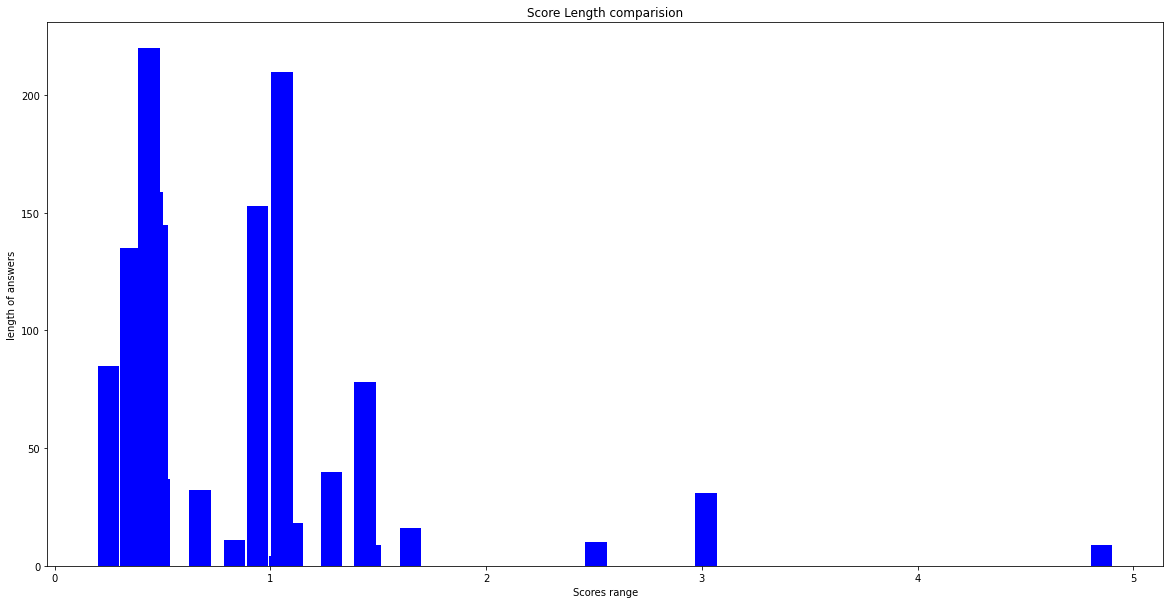

In [47]:
score=[]
length =[]
for i in range(20):
  score.append(valid_answers[i]['score'])
  length.append(len(valid_answers[i]['text']))

print(score)
print(length)
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(score, length, color ='blue',  
        width = 0.1) 
  
plt.xlabel("Scores range") 
plt.ylabel("length of answers") 
plt.title("Score Length comparision") 
plt.show() 
  

In [48]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["test"][5]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 4.8534594, 'text': 'bled and '},
 {'score': 3.0185757, 'text': '. Sequences were assembled and '},
 {'score': 2.5086603, 'text': 'bled and a'},
 {'score': 1.6493661, 'text': 'bled and annotat'},
 {'score': 1.4629529, 'text': '. Sequenc'},
 {'score': 1.4372299,
  'text': 'ions were performed as previously described (3). Sequences were assembled and '},
 {'score': 1.2819654, 'text': 'ribed (3). Sequences were assembled and '},
 {'score': 1.1000681, 'text': 'ere assembled and '},
 {'score': 1.0542297,
  'text': 'coronavirus (DcCoV) HKU23-23-362F strain from the United Arab Emirates (accession no. KF906251), with a nucleotide identity of 99.19%. '},
 {'score': 1.0454994, 'text': ''},
 {'score': 0.94033813,
  'text': 'bled and annotated using the Geneious software (version 5.1.6). We obtained a sequence counting 30,847 nucleotides. The orf1ab, HE, S, ns5, E, M, and N g'},
 {'score': 0.83317846, 'text': 'coronavirus'},
 {'score': 0.67377675, 'text': '. Sequences were assembled and

[4.8534594, 3.0185757, 2.5086603, 1.6493661, 1.4629529, 1.4372299, 1.2819654, 1.1000681, 1.0542297, 1.0454994, 0.94033813, 0.83317846, 0.67377675, 0.4824338, 0.47425163, 0.4509455, 0.4361335, 0.3817718, 0.35343444, 0.25012124]
[9, 31, 10, 16, 9, 78, 40, 18, 135, 0, 153, 11, 32, 37, 145, 159, 220, 60, 135, 85]


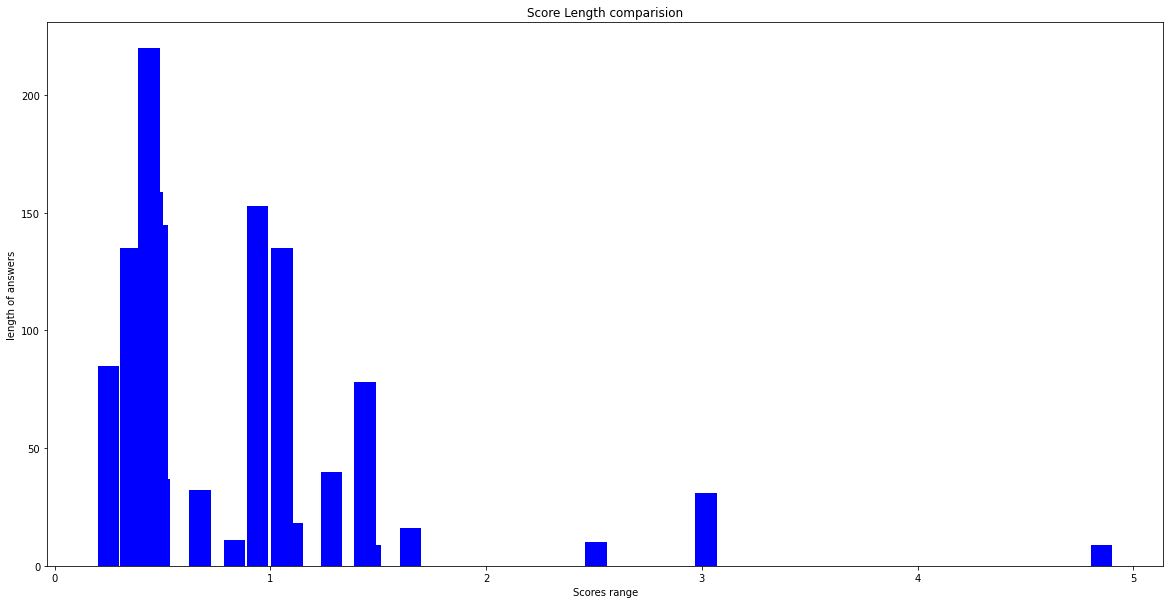

In [49]:
score=[]
length =[]
for i in range(20):
  score.append(valid_answers[i]['score'])
  length.append(len(valid_answers[i]['text']))

print(score)
print(length)
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(score, length, color ='blue',  
        width = 0.1) 
  
plt.xlabel("Scores range") 
plt.ylabel("length of answers") 
plt.title("Score Length comparision") 
plt.show() 
  

In [50]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["test"][10]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 4.8534594, 'text': '. An ELIS'},
 {'score': 3.0185757, 'text': 's available clinically. An ELIS'},
 {'score': 2.5086603, 'text': '. An ELISA'},
 {'score': 1.6493661, 'text': '. An ELISA-array'},
 {'score': 1.4629529, 'text': 's availab'},
 {'score': 1.4372299,
  'text': ' are still no multiple antigen detection methods available clinically. An ELIS'},
 {'score': 1.2819654, 'text': 'on methods available clinically. An ELIS'},
 {'score': 1.1000681, 'text': 'linically. An ELIS'},
 {'score': 1.0542297,
  'text': 'he ELISA-array. The ELISA-array assay is based on a "sandwich" ELISA format and consists of viral antibodies printed directly on 96-well microtiter plates, allowing for direct detection of 5 viruses. '},
 {'score': 1.0454994, 'text': ''},
 {'score': 0.94033813,
  'text': '. An ELISA-array, which detects multiple antigens, is easy to handle, and inexpensive, has enormous potential in pathogen detection. An ELISA-array metho'},
 {'score': 0.83317846, 'text': 'he ELISA-ar'

[4.8534594, 3.0185757, 2.5086603, 1.6493661, 1.4629529, 1.4372299, 1.2819654, 1.1000681, 1.0542297, 1.0454994, 0.94033813, 0.83317846, 0.67377675, 0.4824338, 0.47425163, 0.4509455, 0.4361335, 0.3817718, 0.35343444, 0.25012124]
[9, 31, 10, 16, 9, 78, 40, 18, 200, 0, 153, 11, 32, 37, 145, 159, 220, 60, 135, 85]


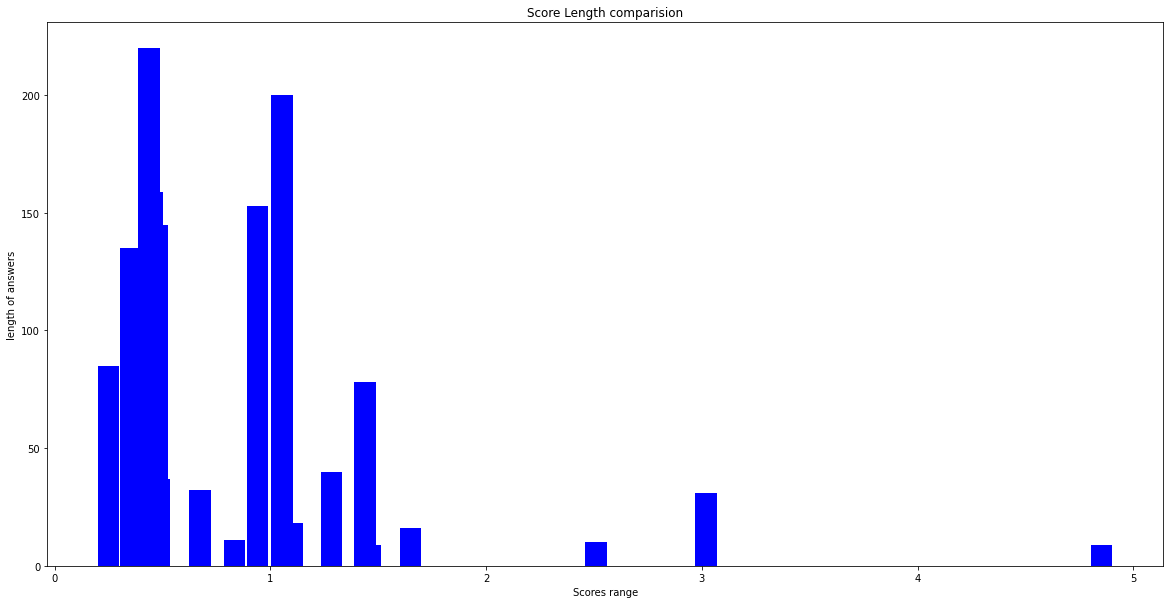

In [51]:
score=[]
length =[]
for i in range(20):
  score.append(valid_answers[i]['score'])
  length.append(len(valid_answers[i]['text']))

print(score)
print(length)
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(score, length, color ='blue',  
        width = 0.1) 
  
plt.xlabel("Scores range") 
plt.ylabel("length of answers") 
plt.title("Score Length comparision") 
plt.show() 
  

In [55]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["test"][20]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 4.8534594, 'text': ' from 0.2'},
 {'score': 3.0185757, 'text': 'ncidence of pneumonia, from 0.2'},
 {'score': 2.5086603, 'text': ' from 0.29'},
 {'score': 1.6493661, 'text': ' from 0.29 episo'},
 {'score': 1.4629529, 'text': 'ncidence '},
 {'score': 1.4372299,
  'text': 'est that there has been a 25% decrease in the incidence of pneumonia, from 0.2'},
 {'score': 1.2819654, 'text': ' in the incidence of pneumonia, from 0.2'},
 {'score': 1.1000681, 'text': 'neumonia, from 0.2'},
 {'score': 1.0542297, 'text': 'lion in 2000 to 900,000 in 2013. '},
 {'score': 1.0454994, 'text': ''},
 {'score': 0.94033813,
  'text': ' from 0.29 episodes per child year in low-and middle-income countries in 2000, to 0.22 episodes per child year in 2010. This is substantiated by a 58% de'},
 {'score': 0.83317846, 'text': 'lion in 200'},
 {'score': 0.67377675, 'text': 'ncidence of pneumonia, from 0.29'},
 {'score': 0.4824338, 'text': ' the incidence of pneumonia, from 0.2'},
 {'score': 0.47425163,
  '

[4.8534594, 3.0185757, 2.5086603, 1.6493661, 1.4629529, 1.4372299, 1.2819654, 1.1000681, 1.0542297, 1.0454994, 0.94033813, 0.83317846, 0.67377675, 0.4824338, 0.47425163, 0.4509455, 0.4361335, 0.3817718, 0.35343444, 0.25012124]
[9, 31, 10, 16, 9, 78, 40, 18, 33, 0, 153, 11, 32, 37, 145, 159, 220, 60, 135, 33]


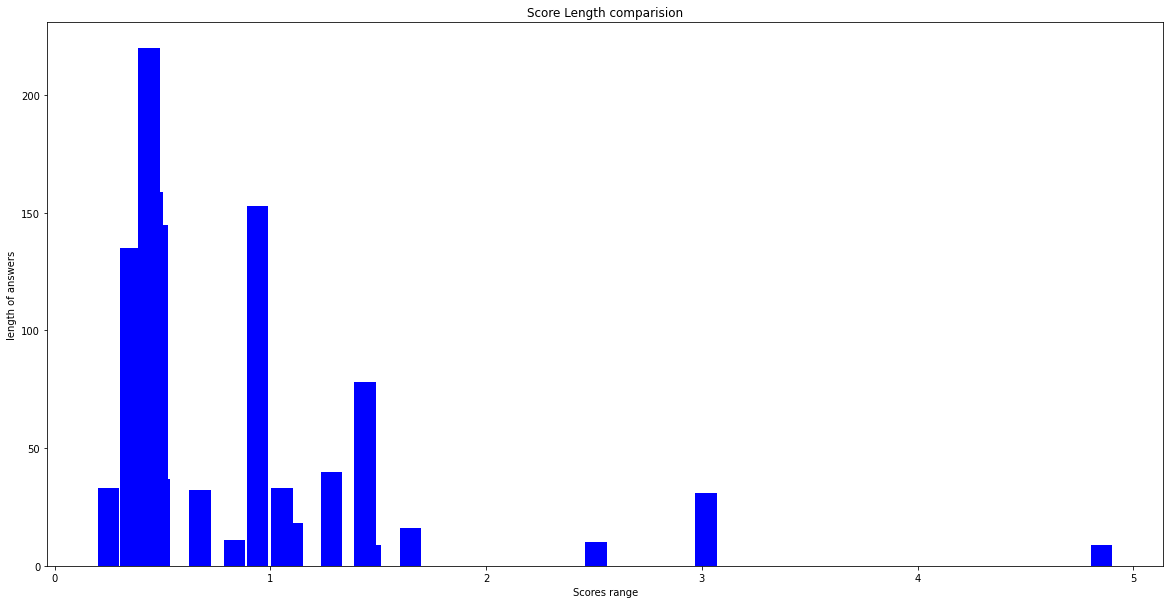

In [56]:
score=[]
length =[]
for i in range(20):
  score.append(valid_answers[i]['score'])
  length.append(len(valid_answers[i]['text']))

print(score)
print(length)
fig = plt.figure(figsize = (20, 10)) 
  
# creating the bar plot 
plt.bar(score, length, color ='blue',  
        width = 0.1) 
  
plt.xlabel("Scores range") 
plt.ylabel("length of answers") 
plt.title("Score Length comparision") 
plt.show() 
  

In [57]:
datasets["test"][20]["answers"]

"{'text': 'Recent data suggest that there has been a 25% decrease in the incidence of pneumonia, from 0.29 episodes per child year in low-and middle-income countries in 2000, to 0.22 episodes per child year in 2010. This is substantiated by a 58% decrease in pneumonia-associated disability-adjusted life years between 1990 and 2013, from 186 million to 78 million ', 'answer_start': 0}"

Here I saw the higer score usually gives small answers and less score is giving you little longer answers